In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 读取数据
file_path = "康复医学科一病房数据.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# 选择特征和目标变量
features = df[['门诊患者人次数', '药品总收入', '当日病房收入']]
target = df['门诊收入OBS_T01_MZSR68']

# 处理缺失值（例如，用中位数填充）
features = features.fillna(features.median())
target = target.fillna(target.median())

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 将特征和目标拼接
df_full = pd.DataFrame(features_scaled, columns=['门诊患者人次数', '药品总收入', '当日病房收入'])
df_full['门诊收入OBS_T01_MZSR68'] = target.values

# 划分训练和测试集（80%训练，20%测试）
train_size = int(len(df_full) * 0.8)
train, test = df_full[:train_size], df_full[train_size:]


In [14]:
# 训练SARIMA模型
model = SARIMAX(train['门诊收入OBS_T01_MZSR68'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# 预测测试集
forecast = model_fit.forecast(steps=len(test))


In [15]:
# 将预测值和实际值转换为分类标签
actual_labels = (test['门诊收入OBS_T01_MZSR68'].diff().fillna(0) > 0).astype(int)
predicted_labels = (forecast.diff().fillna(0) > 0).astype(int)

# 计算分类指标
accuracy = accuracy_score(actual_labels, predicted_labels)
f1 = f1_score(actual_labels, predicted_labels)
auc = roc_auc_score(actual_labels, forecast)

print(f"准确性（Accuracy）: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC面积: {auc}")


准确性（Accuracy）: 0.391304347826087
F1-score: 0.36363636363636365
AUC面积: 0.4846153846153846


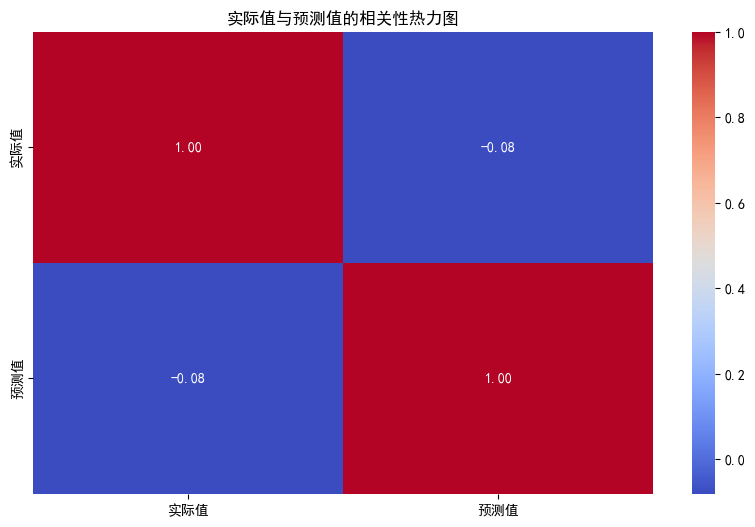

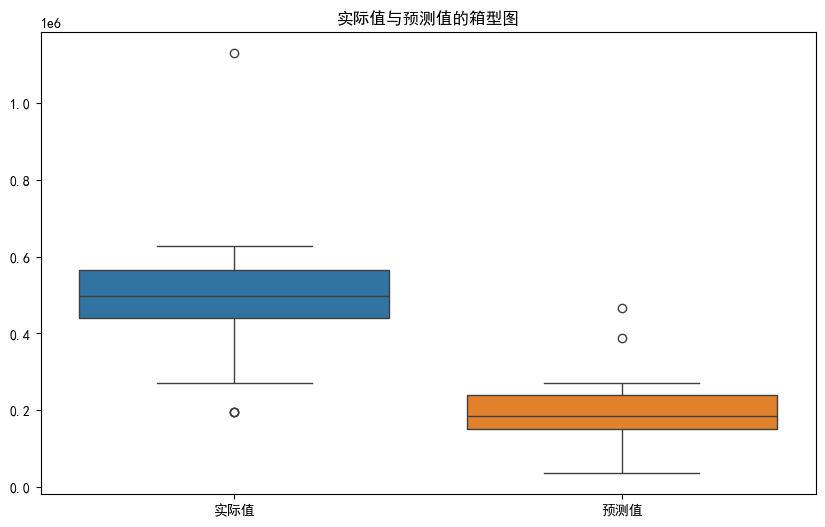

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个包含实际值和预测值的DataFrame
results_df = pd.DataFrame({
    '实际值': test['门诊收入OBS_T01_MZSR68'].values,
    '预测值': forecast
})

# 热力图
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('实际值与预测值的相关性热力图')
plt.show()

# 箱型图
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df)
plt.title('实际值与预测值的箱型图')
plt.show()


In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# 读取数据
df = pd.read_excel('康复一未原始数据.xlsx', sheet_name=0)
data = df['门诊收入OBS_T01_MZSR68'].fillna(df['门诊收入OBS_T01_MZSR68'].mean())

# 检验平稳性
result = adfuller(data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# 网格搜索进行参数优化
import itertools

# 定义参数范围
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
m = 12 # 季节周期

# 生成参数组合
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print(f'SARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results

        except Exception as e:
            print(e)
            continue

print(f'Best SARIMA{best_pdq}x{best_seasonal_pdq}12 - AIC:{best_aic}')


ADF Statistic: -4.6388515722981225
p-value: 0.0001094664772280276
SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3719.9240518949186
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3333.4334179062243
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3246.6189080275626
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2871.521883439842
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3268.1788545623735
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3201.042135587065
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2903.5569339983963
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2859.8870365160296
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3619.9187655455908
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3270.436024760334
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3195.552425450651
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2835.7709051515117
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3314.7853182809026
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3253.6353838145787
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2896.5220113700598
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2834.100340844985
SARIMA(0, 0, 2)x(0, 0, 0, 1

准确率（Accuracy）、F1-score、AUC面积（Area Under the Curve, ROC曲线下面积）是分类问题中常用的评价指标。这些指标帮助我们评估模型的预测性能。虽然在时间序列回归问题中使用这些指标并不常见，但它们在分类任务中具有重要意义。

### 1. **准确率（Accuracy）**
准确率是正确预测的样本占总样本的比例。它表示模型在测试数据中正确分类的总体比例。

公式：
\[ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} \]

- TP: 真阳性（True Positive），即预测为正类且实际为正类的样本数。
- TN: 真阴性（True Negative），即预测为负类且实际为负类的样本数。
- FP: 假阳性（False Positive），即预测为正类但实际为负类的样本数。
- FN: 假阴性（False Negative），即预测为负类但实际为正类的样本数。

**理解**: 准确率越高，模型预测的正确性越高。

### 2. **F1-score**
F1-score是精确率（Precision）和召回率（Recall）的调和平均值，用于衡量模型的准确性和完备性。

公式：
\[ \text{F1-score} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \]

- 精确率（Precision）: \[ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} \]
- 召回率（Recall）: \[ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} \]

**理解**: F1-score提供了模型在处理正类和负类样本时的一种平衡。如果F1-score高，说明模型在准确性和完备性上表现良好。

### 3. **AUC面积（AUC-ROC Curve）**
AUC-ROC曲线下的面积，用于评估分类器的性能。ROC曲线是以假阳性率（FPR）为横轴，真阳性率（TPR）为纵轴绘制的曲线。

- 假阳性率（FPR）: \[ \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}} \]
- 真阳性率（TPR）: \[ \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}} \]

**理解**: AUC值越接近1，模型的性能越好。AUC = 0.5 表示模型没有分类能力，相当于随机猜测。

这些指标在评估分类模型时有不同的侧重点。准确率关注整体预测的正确性，F1-score在数据不平衡情况下提供平衡的性能度量，而AUC则关注模型区分正负类的能力。对于时间序列预测任务，我们将回归问题转换为分类问题，以使用这些指标。